## Assignment 4 - Riley Gavigan

### Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision import models
from PIL import Image
import torch

### Step 1

In [2]:
# Getting all image paths
image_paths = []
for root, dirs, files in os.walk('./images'):
    for file in files:
        if file.endswith('.jpg'):
            image_paths.append(os.path.join(root, file))

# Layers
layers = ['Conv1', 'Conv2', 'Conv3', 'Conv4', 'Conv5', 'fc6', 'fc7']

# Initializing feature maps for each layer
feature_maps = {layer: [] for layer in layers}

with torch.no_grad():
    for layer in layers:
        # Model for current layer
        model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
        layer_index = int(layer[-1])
        model = torch.nn.Sequential(*list(model.features.children())[:layer_index+1])
        model.eval()

        for image_path in image_paths:
            # Preprocessing the image
            image = Image.open(image_path).convert('RGB')
            image_tensor = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
            ])(image)

            mean = image_tensor.mean()
            std = image_tensor.std()

            # Normalizing with mean and std
            transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[mean.item(), mean.item(), mean.item()],
                                     std=[std.item(), std.item(), std.item()]),
            ])
            image_tensor = transform(image).unsqueeze(0)

            # Extract feature map for the current layer
            feature_map = model(image_tensor).squeeze().detach().numpy()
            feature_maps[layer].append(feature_map)

# Vectorize the activations corresponding to each image
for layer in layers:
    feature_maps[layer] = np.array(feature_maps[layer]).reshape(len(image_paths), -1)

### Step 2

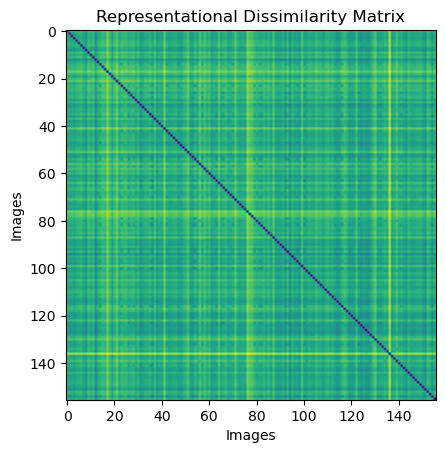

In [3]:
# Create RDM for each layer
rdms = {}
for layer in layers:
    feature_maps[layer] = np.array(feature_maps[layer])
    n = feature_maps[layer].shape[0]
    rdms[layer] = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            rdms[layer][i, j] = np.linalg.norm(feature_maps[layer][i] - feature_maps[layer][j])

# Create main RDM
main_rdm = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        main_rdm[i, j] = np.linalg.norm(feature_maps[layer][i] - feature_maps[layer][j])

# Plot the main RDM
plt.imshow(main_rdm)
plt.title('Representational Dissimilarity Matrix')
plt.xlabel('Images')
plt.ylabel('Images')
plt.show()

### Step 3

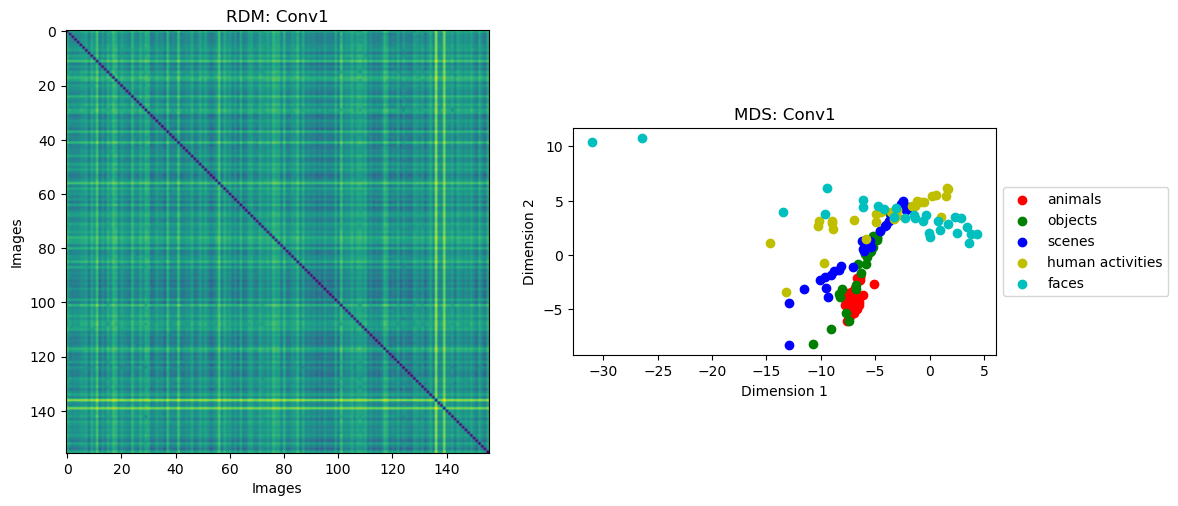

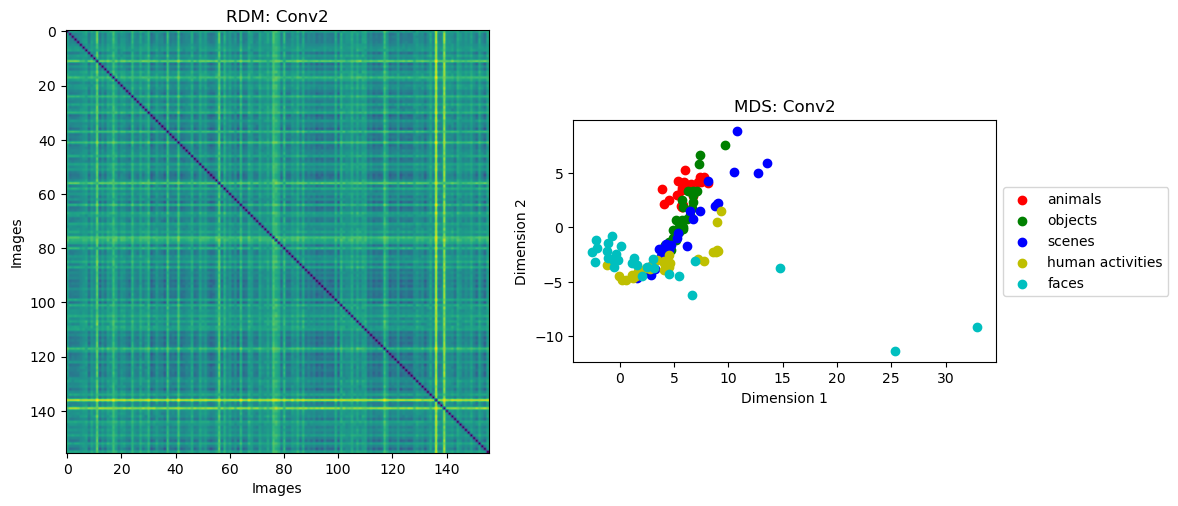

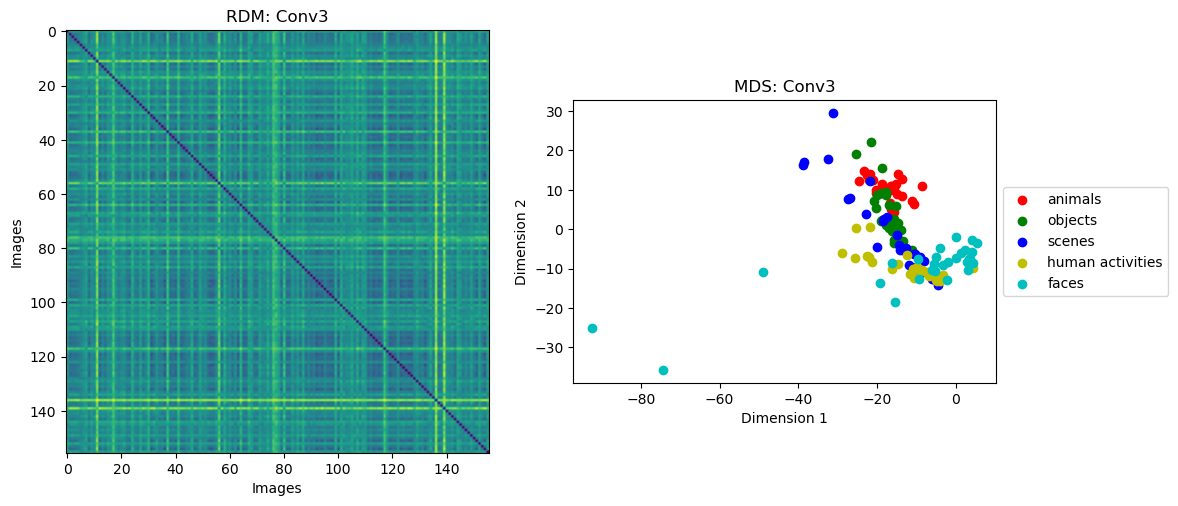

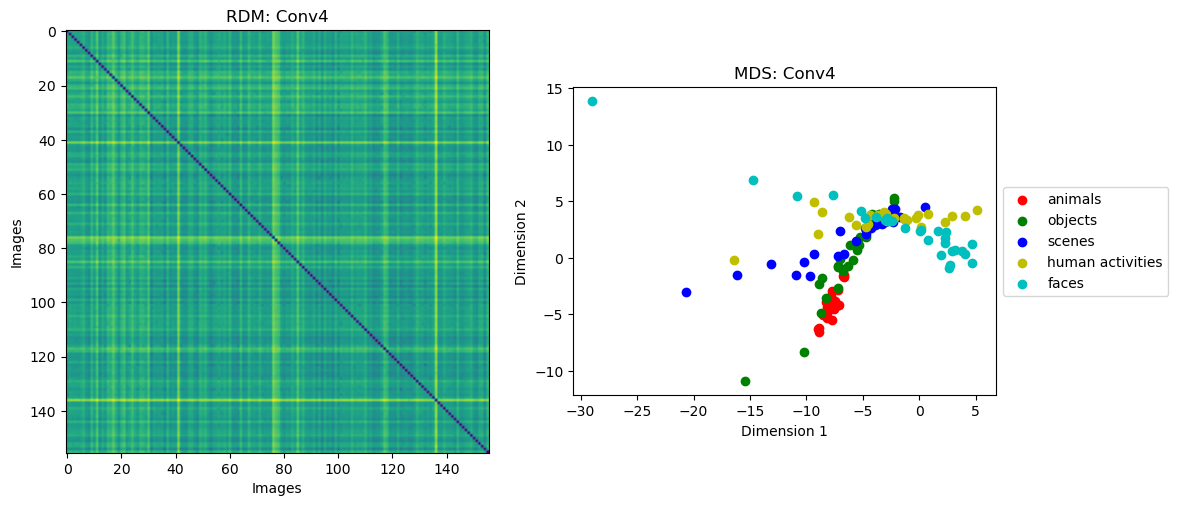

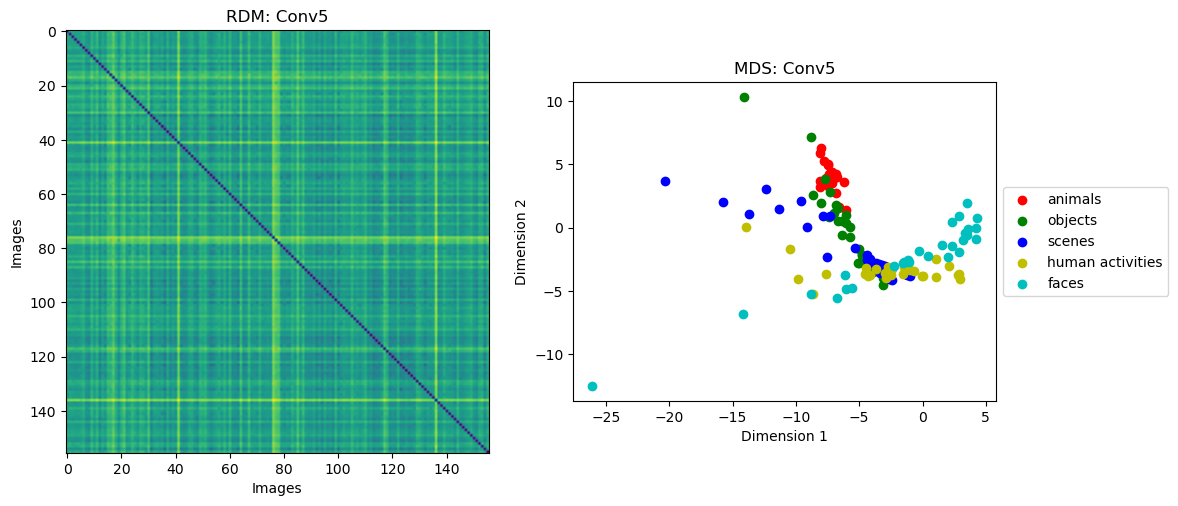

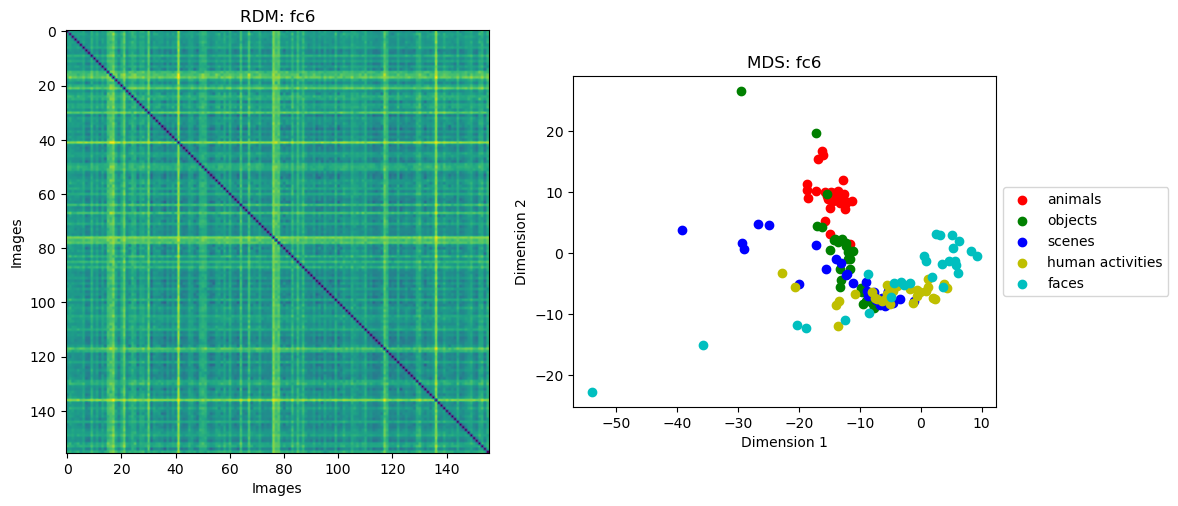

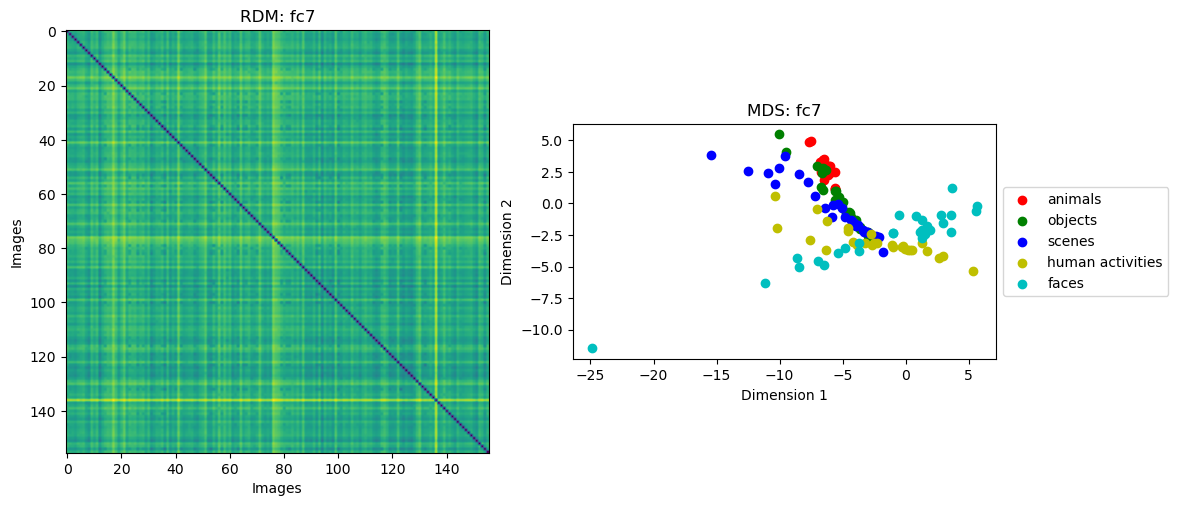

In [4]:
# Plot RDM for each layer and corresponding MDS
for _, layer in enumerate(layers):
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    axs[0].imshow(rdms[layer])
    axs[0].set_title('RDM: ' + layer)

    # Labels of 'Images' for the RDM x and y
    axs[0].set_xlabel('Images')
    axs[0].set_ylabel('Images')
    
    # MDS
    dissimilarity_matrix = rdms[layer]
    n = dissimilarity_matrix.shape[0]
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            distances[i, j] = np.sqrt(np.sum((feature_maps[layer][i] - feature_maps[layer][j]) ** 2))
    
    # Center the distances
    centered_distances = distances - np.mean(distances, axis=0)
    
    # Compute the eigenvalues and eigenvectors of the centered distances
    eigenvalues, eigenvectors = np.linalg.eigh(centered_distances)
    
    # Sort the eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    # Select the top 2 eigenvectors
    top_eigenvectors = eigenvectors[:, :2]
    
    # Compute the MDS coordinates
    mds_coordinates = np.dot(np.sqrt(np.diag(eigenvalues[:2])), top_eigenvectors.T).T
    
    # Set aspect ratio to 'equal' for square plot
    axs[1].set_aspect('equal')
    
    # Unique scatter colour for images 1-28, 29-64, 65-100, 101-124, 125-156 (animals, objects, scenes, human activities, faces)
    colours = ['r', 'g', 'b', 'y', 'c']
    labels = ['animals', 'objects', 'scenes', 'human activities', 'faces']
    for j in range(5):
        axs[1].scatter(mds_coordinates[j*28:(j+1)*28, 0], mds_coordinates[j*28:(j+1)*28, 1], c=colours[j], label=labels[j])
    axs[1].set_title('MDS: ' + layer)

    # Dimension 1 and 2 labels
    axs[1].set_xlabel('Dimension 1')
    axs[1].set_ylabel('Dimension 2')

    # Legend for colours outside the plots
    axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()